In [2]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import collections
from collections import Counter
from bs4 import BeautifulSoup
from word_mapping import word_mapping
import re
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
""" collecting training data """

train_dataset = load_dataset("cnn_dailymail", "3.0.0")
train_raw_data = train_dataset['train'].to_pandas()
train_columns = train_raw_data[['article', 'highlights']]
train_data = pd.DataFrame(train_columns)
train_data.drop_duplicates(subset=['article'], inplace=True)
train_data

,article,highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa..."
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non..."
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical..."
...,...,...
287108,"The nine-year-old daughter of a black, unarmed...","Rumain Brisbon, 34, was killed after Phoenix p..."
287109,Legalising assisted suicide is a slippery slop...,"Theo Boer, a European assisted suicide watchdo..."
287110,A group calling itself 'The Women of the 99 Pe...,Ohio congressman criticised for 'condoning the...
287111,Most men enjoy a good pint of lager or real al...,The Black Country Ale Tairsters have been to 1...


In [11]:
""" collecting testing data """

test_dataset = load_dataset("cnn_dailymail", "3.0.0")
test_raw_data = test_dataset['test'].to_pandas()
test_columns = test_raw_data[['article', 'highlights']]
test_data = pd.DataFrame(test_columns)
test_data.drop_duplicates(subset=['article'], inplace=True)
test_data

,article,highlights
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b..."
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...
...,...,...
11485,Telecom watchdogs are to stop a rip-off that a...,Operators are charging up to 20p a minute - ev...
11486,The chilling reenactment of how executions are...,Bali Nine ringleaders will face the firing squ...
11487,It is a week which has seen him in deep water ...,Hardy was convicted of domestic abuse against ...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...


In [12]:
stop_words = set(stopwords.words('english'))

def text_cleaner(text):
    
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([word_mapping[t] if t in word_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i) 
    text = " ".join(long_words).strip()
    def no_space(word, prev_word):
        return word in set(',!"";.''?') and prev_word!=" "
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text)]
    text = ''.join(out)

    return text


In [14]:
train_data['clean_article'] = train_data['article'].apply(text_cleaner)
train_data['clean_highlights'] = train_data['highlights'].apply(text_cleaner)
train_data['clean_highlights'] = train_data['clean_highlights'].replace('', np.nan)
train_data.dropna(axis=0, inplace=True)
train_data

C:\Users\Jeel Patel\AppData\Local\Temp\ipykernel_10336\1084258250.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  newString = BeautifulSoup(newString, "lxml").text


,article,highlights,clean_article,clean_highlights
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,london england harry potter star daniel radcli...,harry potter star daniel radcliffe gets fortun...
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,editor note behind scenes series cnn correspon...,mentally ill inmates miami housed forgotten fl...
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",minneapolis minnesota drivers minneapolis brid...,new thought going die driver says man says pic...
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",washington doctors removed five small polyps p...,five small polyps found procedure none worriso...
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",national football league indefinitely suspende...,new nfl chief atlanta falcons owner critical m...
...,...,...,...,...
287108,"The nine-year-old daughter of a black, unarmed...","Rumain Brisbon, 34, was killed after Phoenix p...",nine year old daughter black unarmed man shot ...,rumain brisbon killed phoenix police say offic...
287109,Legalising assisted suicide is a slippery slop...,"Theo Boer, a European assisted suicide watchdo...",legalising assisted suicide slippery slope tow...,theo boer european assisted suicide watchdog s...
287110,A group calling itself 'The Women of the 99 Pe...,Ohio congressman criticised for 'condoning the...,group calling women percent making robocalls a...,ohio congressman criticised condoning war wome...
287111,Most men enjoy a good pint of lager or real al...,The Black Country Ale Tairsters have been to 1...,men enjoy good pint lager real ale watching fo...,black country ale tairsters pubs hotels wine b...


In [42]:
test_data['clean_chapter'] = test_data['chapter'].apply(text_cleaner)
test_data['clean_summary_text'] = test_data['summary_text'].apply(text_cleaner)
test_data['clean_summary_text'] = test_data['clean_summary_text'].replace('', np.nan)
test_data.dropna(axis=0, inplace=True)
test_data

,chapter,summary_text,clean_chapter,clean_summary_text
0,"\nAll states, all powers, that have held and h...",Machiavelli prefaces The Prince with a letter ...,states powers held hold rule men either republ...,machiavelli prefaces prince letter magnificent...
1,Considering the difficulties which men have ha...,There are two kinds of kingdoms: those in whic...,considering difficulties men hold newly acquir...,two kinds kingdoms prince sole ruler power spl...
2,\nAlthough a prince may rise from a private st...,"""On Those Who Have Become Princes By Crime,"" i...",although prince may rise private station two w...,become princes crime one key chapters prince m...
3,\nIt is necessary to consider another point in...,"Chapter X is entitled ""How to Measure the Stre...",necessary consider another point examining cha...,chapter entitled measure strength prince state...
4,\nIt only remains now to speak of ecclesiastic...,"""Of Ecclesiastical States,"" primarily concerns...",remains speak ecclesiastical principalities to...,ecclesiastical states primarily concerns papal...
...,...,...,...,...
1426,ACT III SCENE I.\n\n--At SIR PETER'S\n\n S...,"Scene I opens again on Sir Oliver, Sir Peter, ...",act iii scene sir peter sir peter sir oliver r...,scene opens sir oliver sir peter rowley rowley...
1427,SCENE II.\n\n--At CHARLES's House\n\n Ente...,"Scene II opens with Sir Oliver, Mr. Moses, and...",scene charles house enter trip moses sir olive...,scene opens sir oliver moses one charles serva...
1428,"SCENE III.\n\n--CHARLES, CARELESS, etc., etc.\...",Scene III shows Charles and his friends drinki...,scene iii charles careless etc etc table wine ...,scene iii shows charles friends drinking talki...
1429,ACT IV SCENE I.\n\n--A Picture Room in CHARLE...,Charles sells every painting of his ancestors ...,act scene picture room charles surface house e...,charles sells every painting ancestors except ...


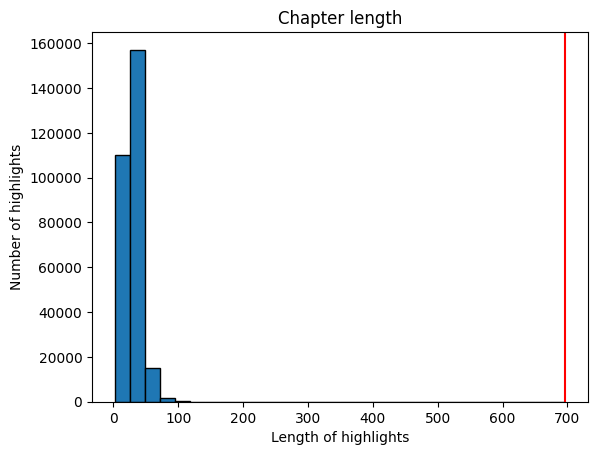

<Figure size 3000x2000 with 0 Axes>

In [15]:
""" Word count distribution for highlights """

import matplotlib.pyplot as plt

higlights_word_count = []

for i in train_data['clean_highlights']:
    higlights_word_count.append(len(i.split()))

plt.hist(higlights_word_count, bins = 30, edgecolor = 'black')
plt.axvline(x=np.max(higlights_word_count), color='red')
plt.xlabel('Length of highlights')
plt.ylabel('Number of highlights')
plt.title('Chapter length')
plt.figure(figsize=(30, 20))
plt.show()

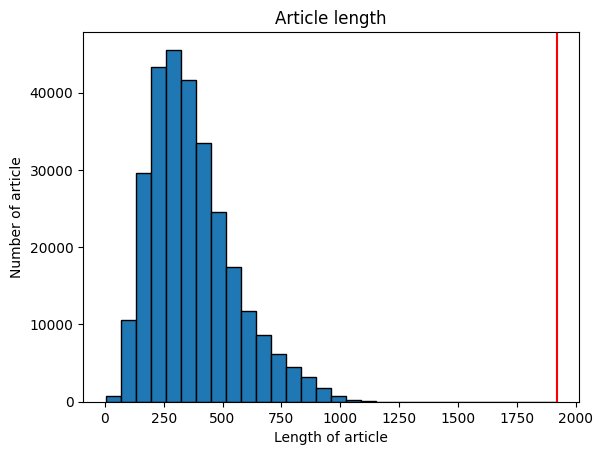

<Figure size 3000x2000 with 0 Axes>

In [16]:
""" Word count distribution for article """

article_word_count = []

for i in train_data['clean_article']:
    article_word_count.append(len(i.split()))

plt.hist(article_word_count, bins = 30, edgecolor = 'black')
plt.axvline(x=np.max(article_word_count), color='red')
plt.xlabel('Length of article')
plt.ylabel('Number of article')
plt.title('Article length')
plt.figure(figsize=(30, 20))
plt.show()


In [19]:
max_len_chapter = 1250
max_len_summary = 150

In [22]:
""" Tokenize function """

def tokenize(lines, token='word'):

    assert token in ('word', 'char'), 'Unknown token type: ' + token
    
    return [line.split() if token == 'word' else list(line) for line in lines]


In [23]:
""" Padding function """

def truncate_pad(line, num_steps, padding_token):

    if len(line) > num_steps:
        return line[:num_steps]    # truncate
    
    return line + [padding_token] * (num_steps - len(line))    # padding


In [24]:
""" The Vocabulary Class """

class Vocab:

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):

        # flatten a 2D list
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]

        # count the token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # the list of unique tokens
        self.idx_to_token = ['<unk>'] + reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
    
    def __len__(self):
        return len(self.idx_to_token)


    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]


    def to_tokens(self, indices):
        if hasattr(indices, '__len__') and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]


    def unk(self):  # Index for the unknown token
        return self.token_to_idx.get('<unk>', -1)
    

In [25]:
input_tokens = tokenize(train_data['clean_article'])
output_tokens = tokenize(train_data['clean_highlights'])

In [26]:
input_vocab = Vocab(input_tokens, reserved_tokens=['<pad>', '<bos>', '<eos>'])
output_vocab = Vocab(output_tokens, reserved_tokens=['<pad>', '<bos>', '<eos>'])

In [27]:
# fn to add eos and padding and also determine valid length of each data sample

def build_array_sum(lines, vocab, num_steps):

    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
    
    return array, valid_len


In [28]:
input_array, src_valid_len = build_array_sum(input_tokens, input_vocab, max_len_chapter)
output_array, tgt_valid_len = build_array_sum(output_tokens, output_vocab, max_len_summary)
data_arrays = (input_array, src_valid_len, output_array, tgt_valid_len)

In [1]:
# create the tensor dataset object 

def load_array(data_arrays, batch_size, is_train=True):

    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 8
data_iter = load_array(data_arrays, batch_size)

NameError: name 'data_arrays' is not defined

In [40]:
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from transformer import *

In [ ]:
""" Initialize model """
model = Transformer(
    src_vocab_size=len(input_vocab),
    tgt_vocab_size=len(output_vocab),
    d_model=512,        
    num_heads=8,        
    num_layers=6,       
    d_ff=2048,          
    max_seq_length=max_len_chapter,
    dropout=0.1
)


""" Define loss function and optimizer """
criterion = CrossEntropyLoss(ignore_index=input_vocab['<pad>'])  
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)


""" Training Loop """
def train_epoch(data_iter, model, criterion, optimizer):
    model.train()
    total_loss = 0
    for src, src_valid_len, tgt, tgt_valid_len in data_iter:
        optimizer.zero_grad()
        
        output = model(src, tgt[:, :-1])  # Pass input and target shifted by one for teacher forcing
        tgt_y = tgt[:, 1:]  # Target labels are offset by one position
        
        # Compute loss
        loss = criterion(output.view(-1, output.shape[-1]), tgt_y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(data_iter)


""" Training Loop over Epochs """
print("Training Loop started...\n")
EPOCHS = 50
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1} started...')
    loss = train_epoch(data_iter, model, criterion, optimizer)
    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.4f}\n')
